---
# Sustained Radiation Events (SREs) - Local Analysis 
---
This notebook provides the analysis of SREs on a local scale along with the SREs analysis of an AR0 process and the observations. 

The data used in this notebook are from CMIP6 Climate models and WRDC observations.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
import warnings

warnings.filterwarnings("ignore", message="All-NaN slice encountered", category=RuntimeWarning)
matplotlib.rcParams.update({'font.size': 24})

--- 
## Loading Data

In [53]:
location       = 'Zurich' # Location of interest

output         = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load SSR data created using the script Get_Data_Local.py

percentiles = np.arange(1, 100, 1) # Choose the percentiles of interest for the maps
min_length  = 3                    # Choose the min SREs length we want to consider
max_length  = 16                   # Choose the min SREs length we want to consider

model_names = {
    'CanESM5':         {'color': 'tab:orange'},
    'CESM2':           {'color': 'g'         },
    'CMCC-CM2-SR5':    {'color': 'c'         },
    'CMCC-ESM2':       {'color': 'm'         },
    'GFDL-CM4':        {'color': 'y'         },
    'GFDL-ESM4':       {'color': 'b'         }, # Main model
    'NorESM2-LM':      {'color': 'tab:purple'},
    'NorESM2-MM':      {'color': 'tab:brown' },
    'TaiESM1':         {'color': 'tab:pink'  },
#     'INM-CM4-8':       {'color': 'tab:gray'  }, # Left out for the analysis
#     'INM-CM5-0':       {'color': 'tab:olive' }, # Left out for the analysis
#     'IPSL-CM5A2-INCA': {'color': 'tab:cyan'  }, # Left out for the analysis
#     'KIOST-ESM':       {'color': 'tab:olive' }  # Left out for the analysis
}

# Create a dictionnary with the simulation length for all models
n_years_dict                     = {}

for model_name in model_names:

    n_years_dict[model_name] = len(output[model_name])//365

# Load the SREs dictionnary giving the SREs occurrence for all models, percentiles and durations
SREs_extreme_events_per_day_dict = pickle.load(open(f'Data/SREs_extreme_events_per_day_dict.pickle', 'rb'))

# If the data is not loaded yet, uncomment the following to create the dictionnary

# SREs_extreme_events_per_day_dict = {}

# for model_name in model_names:

    # print(f'Computing and loading SREs for {mode_name}:')

    # rsds_model               = output[model_name]

    # output_SREs              = my_functions.compute_SREs(rsds_model, percentiles='all', min_length=min_length, max_length=max_length)

    # SREs_extreme_events_per_day_array = np.zeros((len(percentiles), max_length+1))

    # for p, percentile in enumerate(percentiles):

    #     SREs_extreme_events_per_day_array[p,:] = np.sum(output_SREs[percentile]['extreme_events_per_day'], axis = 0)


    # SREs_extreme_events_per_day_dict[model_name] = SREs_extreme_events_per_day_array

# with open(f'Data/SREs_extreme_events_per_day_dict.pickle', 'wb') as f: pickle.dump(SREs_extreme_events_per_day_dict, f)

---
## Slope calculation

We compute the slope of the decadal occurrence as a function of L to quantify the SREs behavior for all models and percentiles.

We are fitting only if there are more than 3 points above or equal to 0.1 event/decade (below this threshold, things are not linear anymore because of the )

In [13]:
slopes     = np.zeros((len(model_names), len(percentiles))).astype(float)
intercepts = np.zeros((len(model_names), len(percentiles))).astype(float)

for m, model_name in enumerate(model_names):

    for i, percentile in enumerate(percentiles):
        
        to_fit = SREs_extreme_events_per_day_dict[model_name][i,:] # Occurrence of SREs
        to_fit = to_fit/n_years_dict[model_name]*10                # Decadal occurrence of SREs
            
        x = np.arange(3,max_length+1) 
        y = to_fit[3:] # We are only interested in L > 2 SREs
        
        index = np.argmax(y < 0.1) # Ignore decadal occurrence below 0.1 event/decade

        if index == 0:
            index = -1

        x_fit = x[:index]
        y_fit = y[:index]
        
        if len(x_fit) > 3: # Fit only if 4 or more points 
            slope, intercept = np.polyfit(x_fit, np.log10(y_fit), 1)
        else:
            slope     = np.nan
            intercept = np.nan

        slopes[m, i]     = slope
        intercepts[m, i] = intercept

---
## Visualise the results

Three plots are illustrating the results:

a) plot showing the decadal occurrence of SREs as a function of L for an example model

b) plot showing the decadal occurrence of SREs as a function of p for an example model

c) plot showing for all models the parameter s_p as a function of p

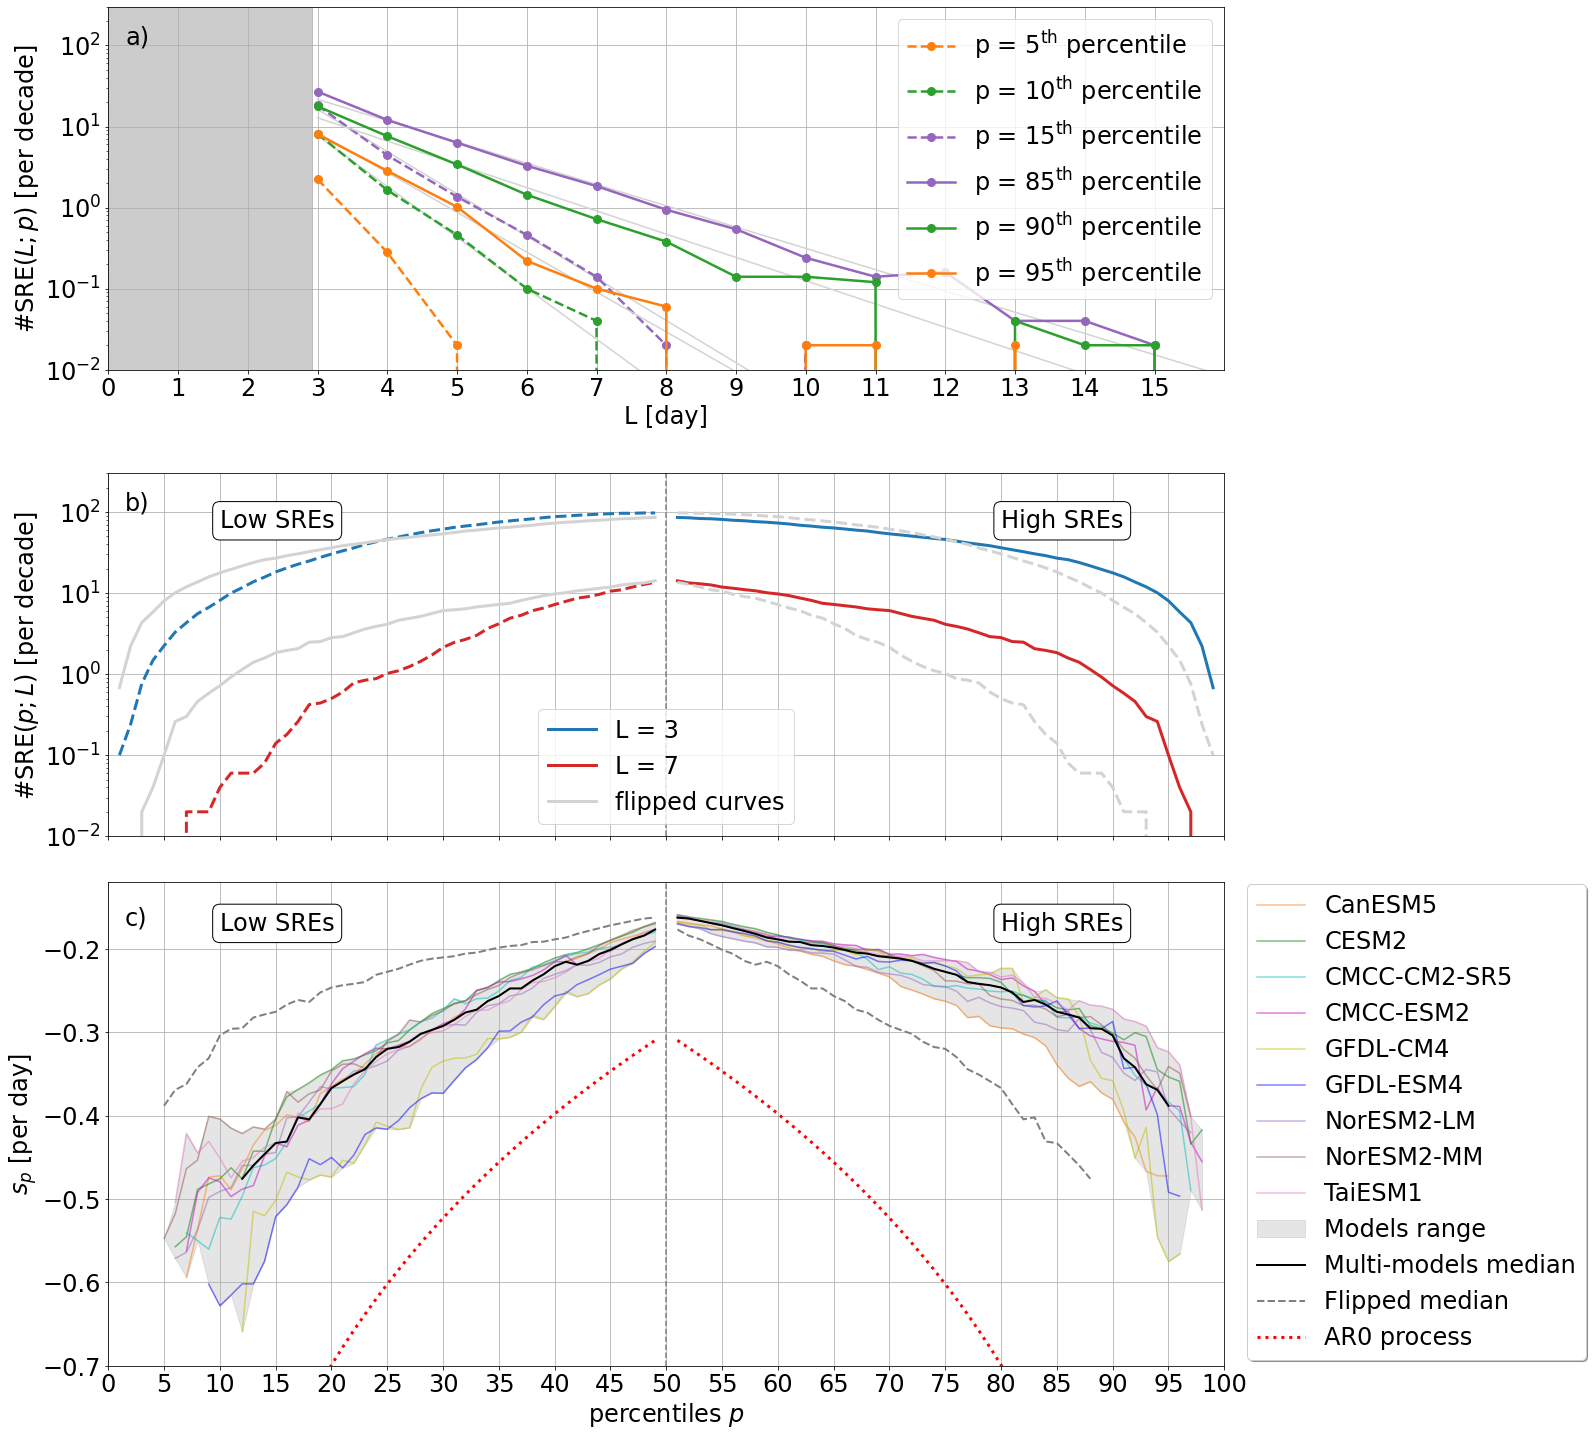

In [33]:
# Set plot parameters
percentiles_to_plot = [5, 10, 15, 85, 90, 95] # Choose the percentiles we want to show (6 complementary percentiles only)
colors_percentiles  = ["tab:orange", "tab:green", "tab:purple"] # Colors for the top plot

L_to_plot           = [3, 7]                  # Choose the lengths we want to show (2 lengths only)
colors_L            = ['tab:blue', 'tab:red']
model_name          = 'GFDL-ESM4'
model_name_index     = [model for model in model_names].index(model_name)



fig = plt.figure(figsize = (20,25))
gs  = fig.add_gridspec(nrows=4, ncols=1, height_ratios=[1.5, 0.05, 1.5, 2], hspace=0.15)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[3])


ax = ax1 # Plot decadal occurrence as function of L for model_name

for p, percentile in enumerate(percentiles_to_plot):
    
    i = percentiles.tolist().index(percentile) # get index corresponding to percentile

    # Set linestyle and color based on the percentile value
    if percentile <= 50:
        linestyle = '--'
        cmap_plot = colors_percentiles[p]
    else:
        linestyle = '-'
        cmap_plot = colors_percentiles[len(percentiles_to_plot)-p-1] # To have the same color for p (p>50) and 100-p

    to_plot = SREs_extreme_events_per_day_dict[model_name][i,:]/n_years_dict[model_name]*10 # Decadal occurrence as a function of L
            
    x = np.arange(3,max_length+1)
    y = to_plot[3:] # We are only interested in L > 2 SREs

    ax.plot(x, np.power(10, slopes[model_name_index, i]*x + intercepts[model_name_index, i]), color = 'lightgray')                                         # Show the fit computed above
    ax.plot(x, y, label=f'p = {percentile}$^{{\mathrm{{th}}}}$ percentile', linestyle=linestyle, marker='o', color=cmap_plot, linewidth=2.5, markersize=8) # Show the decadal occurrence

# Set plot aesthetics and labels
ax.set_xlim(0, x[-1])
ax.fill_betweenx(np.linspace(0,1000), 0, 2.92, color='gray', alpha=0.4)
ax.set_ylim(0.01,300)
ax.set_xticks(np.arange(max_length))
ax.set(xlabel='L [day]', ylabel='$\#\mathrm{SRE}(L;p)$ [per decade]')


ax = ax2 # Plot decadal occurrence as function of p for model_name

for L_index, L in enumerate(L_to_plot):
    
    to_plot = SREs_extreme_events_per_day_dict[model_name][:,L]/n_years_dict[model_name]*10 # Decadal occurrence as a function of p

    ax.plot(percentiles[0:49], to_plot[0:49]      , linestyle = '--', linewidth = 3, color = colors_L[L_index])                         # Show low SREs
    ax.plot(percentiles[50:] , to_plot[50:]       , linestyle = '-' , linewidth = 3, color = colors_L[L_index], label=f'L = {L}')       # Show high SREs
    
    # Show flipped curves 
    ax.plot(percentiles[50:] , to_plot[0:49][::-1], linestyle = '--', linewidth = 3, color = 'lightgray')                              
    if L_index == 1:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray', label='flipped curves')  
    else:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray')                          
    
# Set plot aesthetics and labels
ax.axvline(x=50, color='gray', linestyle='--')

ax.text(.1, .85, f'Low SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax.text(.8, .85, f'High SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax.set(xlabel='', ylabel='$\#\mathrm{SRE}(p;L)$ [per decade]')
ax.set_xticks(np.arange(0,101, 5))
ax.set_xticklabels('')
ax.set_xlim(0, 100)
ax.set_ylim(0.01,300)


ax = ax3 # Plot s_p for all models

# Calculate mins, medians, and maxs for uncertainty later
mins    = np.nanmin(slopes, axis = 0)
medians = np.median(slopes, axis = 0)
maxs    = np.nanmax(slopes, axis = 0)

for m, model_name in enumerate(model_names):

    ax.plot(percentiles[0:49], slopes[m, 0:49], color=model_names[model_name]['color'], alpha = 0.5, label=model_name)
    ax.plot(percentiles[50:], slopes[m, 50:]  , color=model_names[model_name]['color'], alpha = 0.5)

# Grey shading for min/max interval
ax.fill_between(percentiles[0:49], mins[0:49], maxs[0:49], color = 'gray', alpha = .2, label = 'Models range')
ax.fill_between(percentiles[50:] , mins[50:] , maxs[50:] , color = 'gray', alpha = .2)

# Plot multi-model median
ax.plot(percentiles[0:49], medians[0:49], alpha = 1,  linewidth = 2, color = 'black', label = 'Multi-models median')
ax.plot(percentiles[50:] , medians[50:] , alpha = 1, linewidth = 2, color = 'black')

# Plot flipped multi-model median
ax.plot(percentiles[0:49], medians[50:][::-1] , alpha = 1, linewidth = 2, color = 'gray', linestyle = '--', label = 'Flipped median')
ax.plot(percentiles[50:] , medians[0:49][::-1], alpha = 1, linewidth = 2, color = 'gray', linestyle = '--')

# Plot AR0 slopes
ax.plot(np.arange(1,50,1)  , np.log10(np.arange(1,50,1)/100)    , linestyle = 'dotted', linewidth = 3, color = 'red', label = 'AR0 process')
ax.plot(np.arange(51,100,1), np.log10(1-np.arange(51,100,1)/100), linestyle = 'dotted', linewidth = 3, color = 'red')

# Set plot aesthetics and labels
plt.axvline(x=50, color='gray', linestyle='--')

ax.set_ylim(-1,-0.1)
ax.text(.1, .9, f'Low SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax.text(.8, .9, f'High SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax.set_xticks(np.arange(0,101, 5))
ax.set_xticklabels(np.arange(0,101, 5))
ax.set_xlim(0, 100)
ax.set_ylim(-0.7, -0.12)

ax.set_xlabel('percentiles $p$')

ax.set_ylabel('$s_p$ [per day]')
ax.legend(bbox_to_anchor=(1.01, 1.02), ncol=1, fancybox=True, shadow=True) 
ax.grid()

for ax in [ax1, ax2]:

    ax.set_yscale('log') # Set logarithmic y-scale
    ax.legend()
    ax.grid()

ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/SREs_Analysis/Local.png', bbox_inches='tight')
plt.show()

---
## AR0 SREs visualisation

We plot the decadal occurrence of an AR0 process with the same mean and std as our rsds time series from the GFDL-ESM4 model to compare our results with a random process.

SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 500 years (182500 days)

Percentiles considered: [10, 15, 20, 30, 70, 80, 85, 90]

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (182500,): give the daily thresholds for all simulation days
          - rsds_all_years_above (182500,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (182500,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.


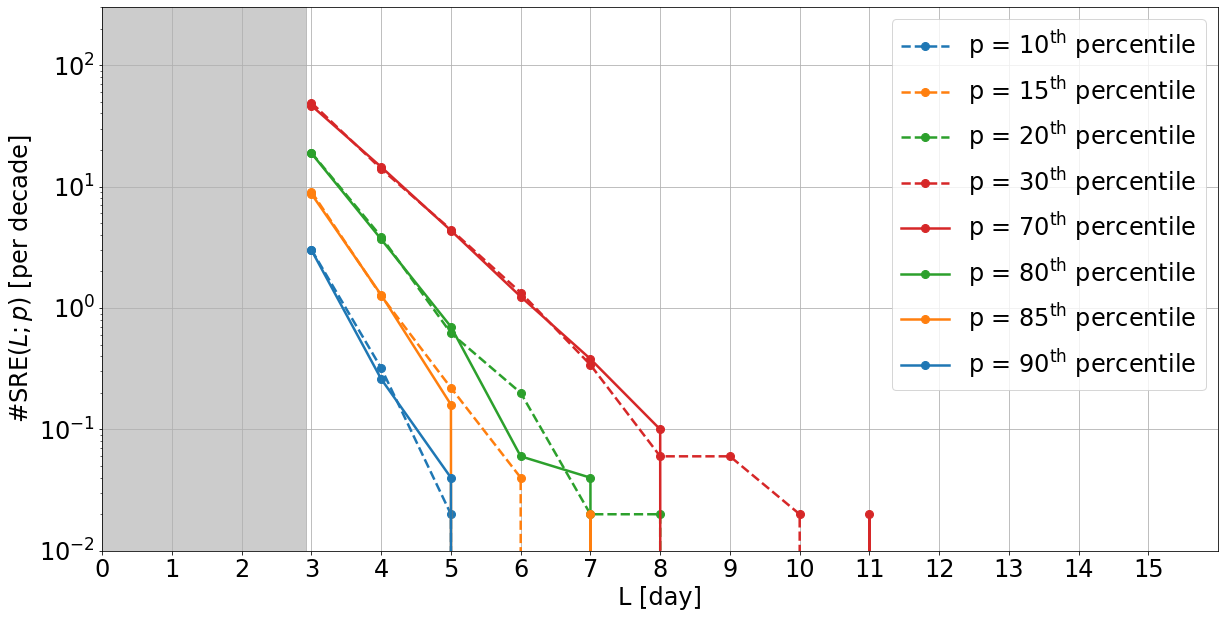

In [44]:
# Set plot parameters
percentiles_to_plot = [10, 15, 20, 30, 70, 80, 85, 90] # Choose the percentiles we want to show (complementary percentiles only)
cmap                = plt.get_cmap('tab10')            # For the colors
rsds                = output['GFDL-ESM4']              # Get the time series for the characteristics

# Compute rsds characteristics 
mean    = np.mean(rsds)
std_dev = np.std(rsds)
length  = len(rsds)

# Generate the AR process with the parameters from above
np.random.seed(0) # Set the random seed for reproducibility
AR0_process = np.random.normal(mean, std_dev, length)

# Compute SREs on the AR0 process
output_SREs_AR0 = my_functions.compute_SREs(AR0_process, percentiles=percentiles_to_plot)

fig = plt.figure(figsize = (20,10))
gs  = fig.add_gridspec(nrows=1, ncols=1)

ax = fig.add_subplot(gs[0])

for p, percentile in enumerate(percentiles_to_plot):
    
    i = percentiles.tolist().index(percentile) # get index corresponding to percentile

    if percentile <= 50:
        linestyle = '--'
        cmap_plot = cmap(p)
    else:
        linestyle = '-'
        cmap_plot = cmap(len(percentiles_to_plot)-p-1)
    
    to_plot = np.sum(output_SREs_AR0[percentile]['extreme_events_per_day'], axis=0)/n_years_dict['GFDL-ESM4']*10 # Decadal occurrence as a function of L
            
    x = np.arange(3,max_length+1)
    y = to_plot[3:] # We are only interested in L > 2 SREs

    ax.plot(x, y, label=f'p = {percentile}$^{{\mathrm{{th}}}}$ percentile', linestyle=linestyle, marker='o', color=cmap_plot, linewidth=2.5, markersize=8)
    
# Set plot aesthetics and labels
ax.set_xlim(0, x[-1])
ax.fill_betweenx(np.linspace(0,1000), 0, 2.92, color='gray', alpha=0.4)
ax.set_ylim(0.01,300)
ax.set_xticks(np.arange(max_length))
ax.set(xlabel='L [day]', ylabel='$\#\mathrm{SRE}(L;p)$ [per decade]')

ax.set_yscale('log') # Set logarithmic y-scale
ax.legend()
ax.grid()

plt.savefig(f'Figures/SREs_Analysis/AR0.png', bbox_inches='tight')
plt.show()

---
## WRDC Observations SREs visualisation

We plot the decadal occurrence of the WRDC observation 38-year time series to compare our results with real life measurements.

See the SSR_Overview notebook for more details about the observations.

In [37]:
file_path = '/net/o3/hymet/lferreira/WRDC_proc/glbrad6/daily/switzerland_zuerich_kloten_zuerich_kloten_daily_proc.txt'

data = np.loadtxt(file_path)

# Extract the relevant columns from the data
day_of_year  = data[:, 1]
rsds_obs     = data[:, 2]


# For the purpose of data formatting, the 366th day of leap years is ignored to ensure the N x 365 format of the data.
valid_indices = np.where(day_of_year != 366) 
rsds_obs      = rsds_obs[valid_indices]

n_years_obs = len(rsds_obs) // 365 

SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 38 years (13870 days)

Percentiles considered: 1th to 99th

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (13870,): give the daily thresholds for all simulation days
          - rsds_all_years_above (13870,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (13870,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.


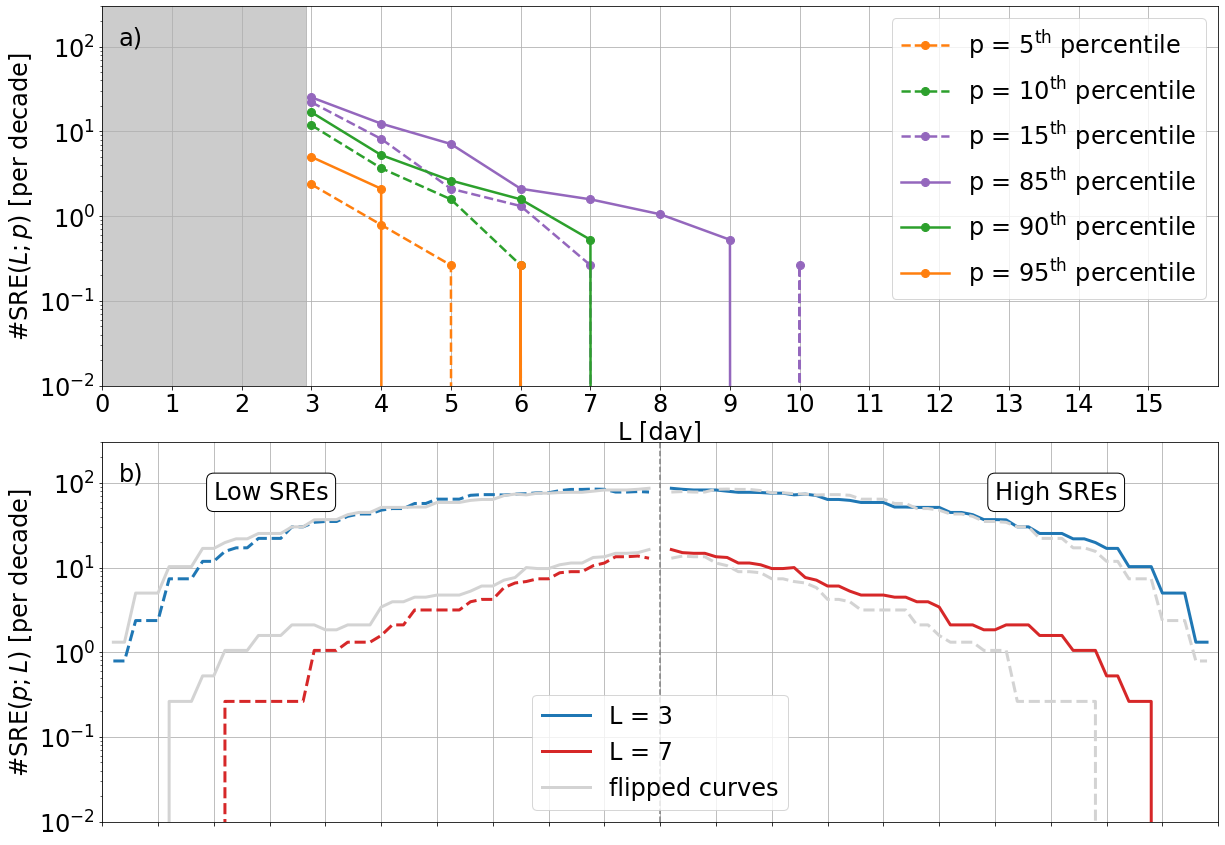

In [52]:
# Set plot parameters
percentiles_to_plot = [5, 10, 15, 85, 90, 95] # Choose the percentiles we want to show (6 complementary percentiles only)
colors_percentiles  = ["tab:orange", "tab:green", "tab:purple"] # Colors for the top plot

L_to_plot           = [3, 7] # Choose the lengths we want to show (2 lengths only)
colors_L            = ['tab:blue', 'tab:red'] # Colors for the bottom plot

# Compute SREs on the observations
output_SREs_Obs = my_functions.compute_SREs(rsds_obs, percentiles='all')


# Built of shape n_percentiles x (max_length+1) to have the SREs occurence of all percentiles and length considered
SREs_extreme_events_per_day_array = np.zeros((len(percentiles), max_length+1))

for p, percentile in enumerate(percentiles):

    SREs_extreme_events_per_day_array[p,:] = np.sum(output_SREs_Obs[percentile]['extreme_events_per_day'], axis = 0)


fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(nrows=2, ncols=1, hspace=0.15)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])


ax = ax1 # Plot decadal occurrence as function of L for model_name

for p, percentile in enumerate(percentiles_to_plot):
    
    i = percentiles.tolist().index(percentile) # get index corresponding to percentile

    # Set linestyle and color based on the percentile value
    if percentile <= 50:
        linestyle = '--'
        cmap_plot = colors_percentiles[p]
    else:
        linestyle = '-'
        cmap_plot = colors_percentiles[len(percentiles_to_plot)-p-1] # To have the same color for p (p>50) and 100-p

    to_plot = SREs_extreme_events_per_day_array[i,:]/n_years_obs*10 # Decadal occurrence as a function of L
            
    x = np.arange(3,max_length+1)
    y = to_plot[3:] # We are only interested in L > 2 SREs

    ax.plot(x, y, label=f'p = {percentile}$^{{\mathrm{{th}}}}$ percentile', linestyle=linestyle, marker='o', color=cmap_plot, linewidth=2.5, markersize=8) # Show the decadal occurrence

# Set plot aesthetics and labels
ax.set_xlim(0, x[-1])
ax.fill_betweenx(np.linspace(0,1000), 0, 2.92, color='gray', alpha=0.4)
ax.set_ylim(0.01,300)
ax.set_xticks(np.arange(max_length))
ax.set(xlabel='L [day]', ylabel='$\#\mathrm{SRE}(L;p)$ [per decade]')


ax = ax2 # Plot decadal occurrence as function of p for model_name

for L_index, L in enumerate(L_to_plot):
    
    to_plot = SREs_extreme_events_per_day_array[:,L]/n_years_obs*10 # Decadal occurrence as a function of L

    ax.plot(percentiles[0:49], to_plot[0:49]      , linestyle = '--', linewidth = 3, color = colors_L[L_index])                         # Show low SREs
    ax.plot(percentiles[50:] , to_plot[50:]       , linestyle = '-' , linewidth = 3, color = colors_L[L_index], label=f'L = {L}')       # Show high SREs
    
    # Show flipped curves 
    ax.plot(percentiles[50:] , to_plot[0:49][::-1], linestyle = '--', linewidth = 3, color = 'lightgray')                              
    if L_index == 1:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray', label='flipped curves')  
    else:
        ax.plot(percentiles[0:49], to_plot[50:][::-1] , linestyle = '-' , linewidth = 3, color = 'lightgray')                          
    
# Set plot aesthetics and labels
ax.axvline(x=50, color='gray', linestyle='--')

ax.text(.1, .85, f'Low SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
ax.text(.8, .85, f'High SREs', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax.set(xlabel='', ylabel='$\#\mathrm{SRE}(p;L)$ [per decade]')
ax.set_xticks(np.arange(0,101, 5))
ax.set_xticklabels('')
ax.set_xlim(0, 100)
ax.set_ylim(0.01,300)

for ax in [ax1, ax2]:

    ax.set_yscale('log') # Set logarithmic y-scale
    ax.legend()
    ax.grid()

ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')

plt.savefig(f'Figures/SREs_Analysis/Observations.png', bbox_inches='tight')
plt.show()